In [1]:
import pandas as pd
import sys

from scipy.optimize import minimize
from scipy.stats import norm, uniform, binom
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal

%run tools.py

## Bayesian linear modeling

Now that we explored in detail the population height, we can finally start our studying on the relationship between weight and height.

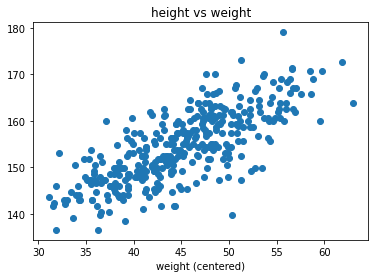

In [2]:
data = pd.read_csv('Howell1.csv', sep = ';')
data1 = data[data.age>=18]

plt.scatter(data1.weight, data1.height)
plt.title('height vs weight')
plt.xlabel('height (cm)')
plt.xlabel('weight (centered)')
plt.show()

The dataset *Howell* contains partial census data for the Dobe area !Kung San, compiled from interviews conducted by Nancy Howell in the late 1960s.

At this point we need to increase a bit the complexity of out Bayesian model, as we are now performing a *regression*.
In particular, we are interested in the relationship:

$$\mbox{height} = a + b * \mbox{weight},$$

and we would like to obtain posterior distributions for the regression coefficients $a$ and $b$. As in classical regression models, the variable $a$ is called *intercept*, and expresses the age we expect when the weight is 0, and $b$ is the *slope*, which indicates how much the height changes for a unit increase of weight.

To proceed with our Bayesian treatment, the trick here is to assume that our previous Gaussian model of height is indeed dependent on the variable weight through this linear relationship. In this case, the height of an individual $i$ is a sample from a Gaussian model:

$$\mbox{height}_i\sim N(\mu_i,\sigma^2),$$

whiel this time we impose that $\mu_i = a + b * \mbox{weight}_i$. Note that while we allow the mean $\mu_i$ to vary depending on the weight, the coefficients $a$ and $b$, as well as the noise $\sigma$ are the same across subjects.  
To completely define our Bayesian model, we need to specify priors for all the parameters we want to analyze:

$$ p(a) = N(178, 1000),$$

$$ p(b) = N(0, 100),$$

$$ p(\sigma) = U(0, 50).$$

We code all these elements to run our black-box machine:

In [3]:
expr = 'height ~   weight'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

And we are finally ready to perform inference:


In [4]:
solution_regression = laplace_solution_regression(expr, data1, likelihood, priors)


      fun: 1083.8791047600625
 hess_inv: array([[ 2.58604045e-02, -4.19664392e-04, -2.29682993e-02],
       [-4.19664392e-04,  3.71082533e-05,  4.63260833e-04],
       [-2.29682993e-02,  4.63260833e-04,  2.37225877e-02]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 208
      nit: 33
     njev: 52
   status: 0
  success: True
        x: array([113.90338356,   0.90450629,   5.07186716])


As before, we can sample from our posterior to explore the distribution of our model parameters: 

In [5]:
posterior_samples = multivariate_normal.rvs(solution_regression[0], solution_regression[1], size = 1000)

# Computing summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples, axis = 0)
# mean
post_mean = np.mean(posterior_samples, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary = pd.DataFrame(summary_stats).transpose()
summary.columns = ['mean', 'SD', '7.5%', '92.5%']
summary.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary)

             mean        SD        7.5%       92.5%
a      113.906565  0.163098  113.668219  114.150647
b        0.904624  0.006300    0.895480    0.913571
sigma    5.070378  0.156107    4.842681    5.292697


We try to run the model again by centering the data, what is the difference in the posteriors? Can you explain this difference?

/home/quentin/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


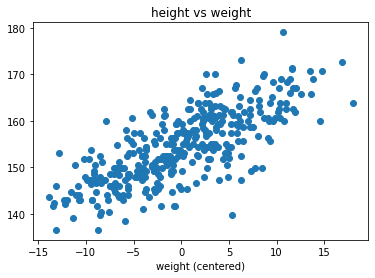

/home/quentin/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 2008.9232128280778
 hess_inv: array([[ 4.40381866, -0.33567445,  0.01487115],
       [-0.33567445,  0.23585008, -0.23990293],
       [ 0.01487115, -0.23990293,  0.56399357]])
      jac: array([ 9.10108948, -3.5581665 , -4.80917358])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 80
      nit: 4
     njev: 17
   status: 2
  success: False
        x: array([219.05677746,   0.29801939,  49.9421    ])


In [7]:
# Centering the data
mean_weight = np.mean(data1.weight)
data_center = data1
data_center.weight = data1.weight - mean_weight

plt.scatter(data_center.weight, data_center.height)
plt.title('height vs weight')
plt.xlabel('height (cm)')
plt.xlabel('weight (centered)')
plt.show()

# Fitting the model again
solution_regression_center = laplace_solution_regression(expr, data_center, likelihood, priors)

In [7]:
# Computing posterior samples
posterior_samples_center = multivariate_normal.rvs(solution_regression_center[0], solution_regression_center[1], size = 1000)

# Computing summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples_center, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples_center, axis = 0)
# mean
post_mean = np.mean(posterior_samples_center, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary_stats = pd.DataFrame(summary_stats).transpose()
summary_stats.columns = ['mean', 'SD', '7.5%', '92.5%']
summary_stats.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary_stats)

             mean        SD        7.5%       92.5%
a      154.601268  0.345384  154.113824  155.093335
b        0.905576  0.037149    0.853232    0.958000
sigma    5.065084  0.184685    4.811073    5.325237


Once obtained the parameters, we can start exploring the model.
Let's plot the average prediction along the entire weight range:

[154.60126844   0.90557568   5.06508359]


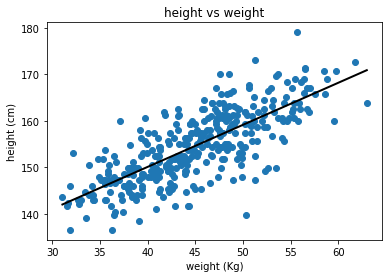

In [8]:
#plotting the average results 
print(post_mean)

x_range = np.linspace(min(data_center.weight), max(data_center.weight))
mean_prediction = post_mean[0] + post_mean[1] * x_range

plt.plot(x_range + mean_weight, mean_prediction, lw = 2, color = 'black')
plt.scatter(data_center.weight + mean_weight,data_center.height)
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')
plt.show()

Now we can explore the variability of the prediction, this can be done by using the posterior samples for the coefficients that we computed before:

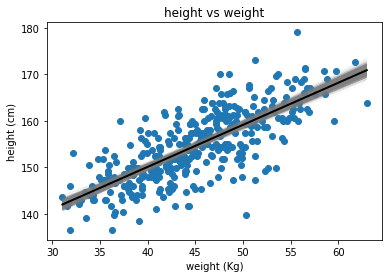

In [9]:
#sampling from the posterior

for i in range(1000):
    prediction = posterior_samples_center[i,0] + posterior_samples_center[i,1] * x_range
    plt.plot(x_range + mean_weight, prediction, lw = 0.05, color = 'grey')

plt.scatter(data_center.weight + mean_weight,data_center.height)
plt.plot(x_range + mean_weight, mean_prediction, lw = 2, color = 'black')
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')


plt.show()

By following the same modeling procedure, we can study how the uncertainty on the estimation of the coefficients varies with the different sample sizes: 

      fun: 71.32545922183954
 hess_inv: array([[ 9.82448235e-01,  2.13220540e-02,  6.47725120e-03],
       [ 2.13220540e-02,  1.61265297e-02, -6.20435599e-04],
       [ 6.47725120e-03, -6.20435599e-04,  5.49641368e-01]])
      jac: array([ 0.00000000e+00, -4.76837158e-06, -9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 96
      nit: 21
     njev: 24
   status: 0
  success: True
        x: array([153.55884659,   0.86866265,   4.74646032])


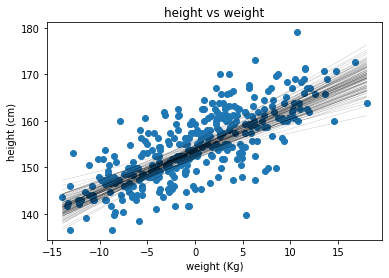

      fun: 161.3106674785745
 hess_inv: array([[ 0.34593936, -0.00333648,  0.01003321],
       [-0.00333648,  0.00792816,  0.00319032],
       [ 0.01003321,  0.00319032,  0.220318  ]])
      jac: array([ 1.90734863e-06,  3.81469727e-06, -1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 120
      nit: 27
     njev: 30
   status: 0
  success: True
        x: array([152.92544958,   0.889712  ,   4.80911436])


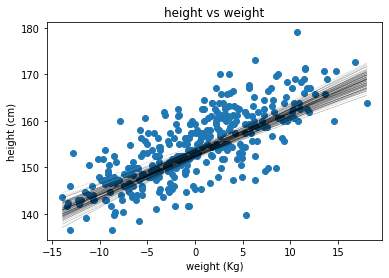

      fun: 478.32116064090275
 hess_inv: array([[ 2.04273353e-01, -2.66942031e-03, -4.43849537e-04],
       [-2.66942031e-03,  4.11022048e-03,  1.72625841e-05],
       [-4.43849537e-04,  1.72625841e-05,  9.75984461e-02]])
      jac: array([-7.62939453e-06, -7.62939453e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 100
      nit: 18
     njev: 25
   status: 0
  success: True
        x: array([153.83813228,   0.90193027,   5.42665167])


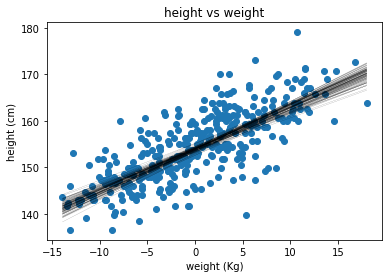

/home/quentin/.local/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 1076.6635796350145
 hess_inv: array([[ 0.05864202, -0.00181562,  0.00655297],
       [-0.00181562,  0.00036089, -0.00041817],
       [ 0.00655297, -0.00041817,  0.0150135 ]])
      jac: array([ 0.00000000e+00, -3.05175781e-05,  1.52587891e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 170
      nit: 27
     njev: 42
   status: 2
  success: False
        x: array([154.62813393,   0.91056832,   5.07189275])


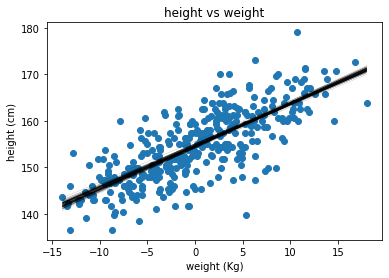

In [10]:
# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 20
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

# Posterior uncertainty vs sample size

for N in [20,50,150,350]:
    
    # Selecting a subset of the data with sample size = N
    sub_data = data_center.head(N)
    # Fitting the model again
    R = laplace_solution_regression(expr, sub_data, likelihood, priors)

    # Computing posterior samples
    post_R = multivariate_normal.rvs(R[0], R[1], size = 1000)

    for i in range(100):
        prediction = post_R[i,0] + post_R[i,1] * x_range
        plt.plot(x_range, prediction, lw = 0.1, color = 'black')

    plt.scatter(data1.weight,data1.height)
    plt.title('height vs weight')
    plt.ylabel('height (cm)')
    plt.xlabel('weight (Kg)')


    plt.show()  

The model also allows us to quantify the uncertainty of the prediction for a single odata point.

**Exercise.** Predict the height distribution for a person of 50Kg.

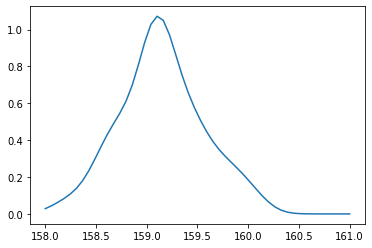

In [11]:
# Prediction for a person of 50Kg

x = 50
x_center = x - mean_weight
prediction = []
for i in range(100):
    prediction.append(posterior_samples_center[i,0] + posterior_samples_center[i,1] * x_center)

data_density = gaussian_kde(prediction)
plt.plot(np.linspace(158,161), data_density(np.linspace(158,161)))
plt.show()

And we can repeat the exercise for the entire range of weights:

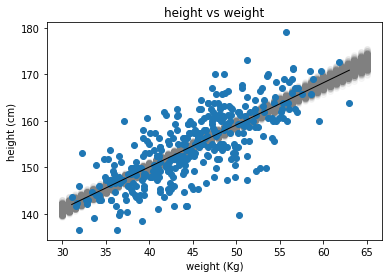

In [12]:
range_x_test = np.linspace(30,65)
x_range_center = range_x_test - mean_weight


prediction_range = []
N_s = len(posterior_samples_center[:,0])

#sampling from the posterior to get a predictive interval
for x_ in (x_range_center):
    prediction_range.append(posterior_samples_center[:,0] + posterior_samples_center[:,1] * x_)  

# Plotting the uncertainty
for i,x_ in enumerate(x_range_center):    
    plt.scatter(np.repeat(x_,N_s) + mean_weight, prediction_range[i], alpha = 0.05, color = 'grey')


#plotting the data
plt.scatter(data1.weight + mean_weight,data1.height)

# Plotting average prediction    
#avg_prediction = post_mean[0] + post_mean[1] * x_range_center
plt.plot(x_range + mean_weight, mean_prediction, lw = 1, color = 'black')

# Plotting +/- sigma theoretical interval
#plt.fill_between(x_range_center + mean_weight, mean_prediction - post_mean[2], mean_prediction + post_mean[2], alpha=0.1, color = 'green', linestyle='dashdot')
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')

plt.show()

So far we analyzed only the uncertainty related to the mean prediction, but we see that many data points fall clearly beyond the confidence interval.  
We can estimate the overall posterior uncertainty of the prediction, while accounting for the estimated regression noise. 
This requires to sample from the data posterior, accounting for the variability for both regression coefficients and modelled noise:

[]

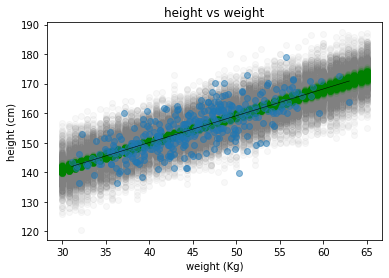

In [13]:
prediction_range = []
#sampling from the posterior to get a predictive interval
for x_ in (x_range_center):
    prediction_range.append(posterior_samples_center[:500,0] + posterior_samples_center[:500,1] * x_)  

prediction_range_noise = []

#sampling from the posterior to get a predictive interval
for x_ in (x_range_center):
    prediction_range_noise.append(norm.rvs(posterior_samples_center[:500,0] + posterior_samples_center[:500,1] * x_,  posterior_samples_center[:500,2]))  
    
# Plotting the uncertainty
for i,x_ in enumerate(x_range_center): 
    plt.scatter(np.repeat(x_,500) + mean_weight, prediction_range_noise[i], alpha = 0.05, color = 'grey')
for i,x_ in enumerate(x_range_center): 
    plt.scatter(np.repeat(x_,500) + mean_weight, prediction_range[i], alpha = 0.05, color = 'green')


plt.scatter(data1.weight + mean_weight,data1.height, alpha = 0.5)
plt.plot(x_range + mean_weight, mean_prediction, lw = 0.5, color = 'black')
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')
plt.plot()

**Exercise.** Include the individual with age less than 18 years, and repeat the analysis. 

Which kind of model would you use for modeling this data?

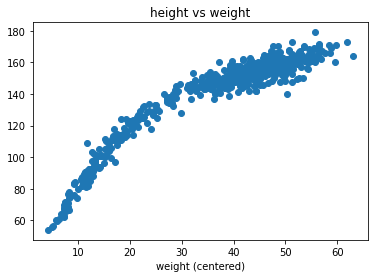

In [14]:
mean_tot_weight = np.mean(data.weight)

data.weight = data.weight - mean_tot_weight

plt.scatter(data.weight + mean_tot_weight, data.height)
plt.title('height vs weight')
plt.xlabel('height (cm)')
plt.xlabel('weight (centered)')
plt.show()

In [15]:
data['weight2'] = data.weight * data.weight

expr = 'height ~   weight + weight2'

print(data.head(10))

    height     weight   age  male     weight2
0  151.765  12.214989  63.0     1  149.205954
1  139.700   0.875189  63.0     0    0.765956
2  136.525  -3.745780  65.0     0   14.030865
3  156.845  17.431297  41.0     1  303.850112
4  145.415   5.666254  51.0     0   32.106439
5  163.830  27.381971  35.0     1  749.772358
6  149.225   2.632858  32.0     0    6.931941
7  168.910  19.869354  27.0     1  394.791225
8  147.955  -0.740733  19.0     0    0.548685
9  165.100  18.877121  54.0     1  356.345713


In [16]:
# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 20
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

prior_b2_mean = 0
prior_b2_sigma = 10
prior_b2 = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_b2, prior_sigma]


solution_regression_quadratic = laplace_solution_regression(expr, data, likelihood, priors)

/home/quentin/.local/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 1738.9532047375162
 hess_inv: array([[ 7.33524292e-02, -1.74606327e-03, -1.94888734e-04,
        -1.03151559e-02],
       [-1.74606327e-03,  3.60875963e-04,  1.10376183e-05,
         3.22859309e-04],
       [-1.94888734e-04,  1.10376183e-05,  1.28166643e-06,
         2.86847190e-05],
       [-1.03151559e-02,  3.22859309e-04,  2.86847190e-05,
         2.88602701e-02]])
      jac: array([0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 235
      nit: 34
     njev: 46
   status: 0
  success: True
        x: array([ 1.46671415e+02,  1.45466307e+00, -3.88570089e-02,  5.74977514e+00])


In [17]:
# Computing posterior samples
posterior_samples_quadratic = multivariate_normal.rvs(solution_regression_quadratic[0], solution_regression_quadratic[1], size = 1000)

# Computing summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples_quadratic, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples_quadratic, axis = 0)
# mean
post_mean = np.mean(posterior_samples_quadratic, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary_stats = pd.DataFrame(summary_stats).transpose()
summary_stats.columns = ['mean', 'SD', '7.5%', '92.5%']
summary_stats.rename(index={0:'a',1:'b', 2:'b2', 3:'sigma'}, inplace=True)
print(summary_stats)

             mean        SD        7.5%       92.5%
a      146.679703  0.281756  146.284037  147.091824
b        1.454673  0.018978    1.426522    1.481389
b2      -0.038866  0.001109   -0.040441   -0.037244
sigma    5.752987  0.177865    5.501111    6.013821


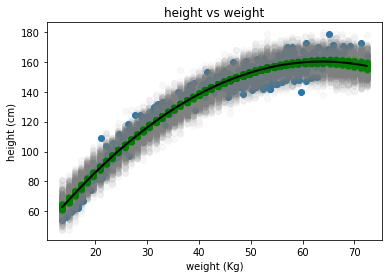

In [18]:
#plotting the average results 
x_range = np.linspace(min(data.weight), max(data.weight))
mean_prediction = post_mean[0] + post_mean[1] * x_range + post_mean[2] * x_range**2

plt.plot(x_range + mean_weight , mean_prediction, lw = 2, color = 'black')
plt.scatter(data.weight + mean_weight, data.height)
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')

prediction_range = []
#sampling from the posterior to get a predictive interval
for x_ in (x_range):
    prediction_range.append(posterior_samples_quadratic[:500,0] + posterior_samples_quadratic[:500,1] * x_ + posterior_samples_quadratic[:500,2] * x_**2)  

prediction_range_noise = []

#sampling from the posterior to get a predictive interval
for x_ in (x_range):
    pred_mean_data = posterior_samples_quadratic[:500,0] + posterior_samples_quadratic[:500,1] * x_ + posterior_samples_quadratic[:500,2] * x_**2
    prediction_range_noise.append(norm.rvs( pred_mean_data,  posterior_samples_quadratic[:500,3]))  
    
# Plotting the uncertainty
for i,x_ in enumerate(x_range): 
    plt.scatter(np.repeat(x_,500) + mean_weight, prediction_range_noise[i], alpha = 0.05, color = 'grey')
for i,x_ in enumerate(x_range): 
    plt.scatter(np.repeat(x_,500) + mean_weight, prediction_range[i], alpha = 0.05, color = 'green')


plt.show()